<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [4]:
import pandas as pd
 
with pd.HDFStore('data/fea_sample/storage_sample_stage4.h5', 'r') as d:
    df = d.get('train_df')
    df.to_csv('final_train.csv')

In [5]:
with pd.HDFStore('data/fea_sample/storage_sample_stage4.h5','r') as d:
    df = d.get('test_df')
    df.to_csv("final_test.csv")

In [6]:
#reading
from pandas import read_hdf
df_final_train1 = pd.read_csv("final_train.csv",index_col=0)
df_final_test1 = pd.read_csv('final_test.csv',index_col=0)

In [7]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


## Feature Engineering

### Preferential Attachment

http://be.amazd.com/link-prediction/

In [8]:
#for followees
def Preferential_Attachment_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a))))*(len(set(train_graph.successors(b))))
    except:
        return 0
    return sim

In [9]:
print(Preferential_Attachment_for_followees(273084,470294))

375


In [10]:
#node 1635354 not in graph 
print(Preferential_Attachment_for_followees(669354,1635354))

0


In [11]:
#for followees
def Preferential_Attachment_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b))))
    except:
        return 0
    return sim

In [12]:
print(Preferential_Attachment_for_followers(273084,470294))

220


In [13]:
#node 1635354 not in graph 
print(Preferential_Attachment_for_followers(669354,1635354))

0


In [14]:
df_final_train1['Preferential_Attachment_followers'] = df_final_train1.apply(lambda row:
                                            Preferential_Attachment_for_followers(row['source_node'],row['destination_node']),axis=1)

df_final_train1['Preferential_Attachment_followees'] = df_final_train1.apply(lambda row:
                                            Preferential_Attachment_for_followees(row['source_node'],row['destination_node']),axis=1)

In [15]:
df_final_test1['Preferential_Attachment_followers'] = df_final_test1.apply(lambda row:
                                            Preferential_Attachment_for_followers(row['source_node'],row['destination_node']),axis=1)

df_final_test1['Preferential_Attachment_followees'] = df_final_test1.apply(lambda row:
                                            Preferential_Attachment_for_followees(row['source_node'],row['destination_node']),axis=1)

In [16]:
df_final_train1.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment_followers,Preferential_Attachment_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108439e-13,1.719704e-14,1.355369e-12,-4.675319e-13,1.128586e-06,-6.616712e-14,9.771079e-13,4.160012e-14,66,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703512e-12,2.251737e-10,-1.244923e-12,1.636950e-10,-3.112886e-10,-6.738902e-02,2.607857e-11,2.372904e-09,1598,8662


In [17]:
df_final_test1.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,Preferential_Attachment_followers,Preferential_Attachment_followees
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,...,4.341620e-13,5.535503e-14,9.994077e-10,-5.791914e-10,3.512351e-07,-2.486660e-09,2.771146e-09,1.727695e-12,84,54
1,483294,1255532,1,0,0.0,0.000000,0.0,17,1,19,...,3.601010e-13,4.701440e-15,9.360663e-12,-3.206811e-10,4.668669e-08,-6.665782e-12,1.495980e-10,9.836692e-14,34,19


In [18]:
y_train = df_final_train1.indicator_link
y_test = df_final_test1.indicator_link

In [19]:
df_final_train1.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test1.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [20]:
df_final_train1.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment_followers',
       'Preferential_Attachment_followees'],
      dtype='object')

### Random Forest Model

Estimators =  10 Train Score 0.9243103682565567 test Score 0.9195976733931084
Estimators =  50 Train Score 0.9196497607255554 test Score 0.914861038280021
Estimators =  100 Train Score 0.9213929101125943 test Score 0.9156434313540288
Estimators =  250 Train Score 0.9213588882963707 test Score 0.9167243949031215
Estimators =  450 Train Score 0.9219721754763722 test Score 0.9148027354024199


Text(0.5,1,'Estimators vs score at depth of 5')

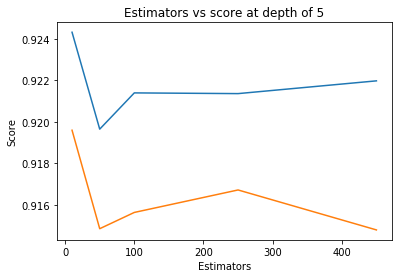

In [21]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train1,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train1))
    test_sc = f1_score(y_test,clf.predict(df_final_test1))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8899905073304504 test Score 0.8673952327682644
depth =  9 Train Score 0.9591757783071693 test Score 0.923628087330355
depth =  11 Train Score 0.9614721337418084 test Score 0.9251066154072394
depth =  15 Train Score 0.9635861733005865 test Score 0.926294527321312
depth =  20 Train Score 0.9636199608729588 test Score 0.9258356106789993
depth =  35 Train Score 0.9637413862991489 test Score 0.9259158067295769
depth =  50 Train Score 0.9637413862991489 test Score 0.9259158067295769
depth =  70 Train Score 0.9637413862991489 test Score 0.9259158067295769
depth =  130 Train Score 0.9637413862991489 test Score 0.9259158067295769


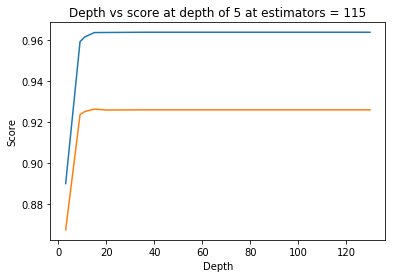

In [22]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train1,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train1))
    test_sc = f1_score(y_test,clf.predict(df_final_test1))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [23]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train1,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96176241 0.96201358 0.96054198 0.96166808 0.96300578]
mean train scores [0.96262319 0.96250995 0.96079947 0.96251071 0.96400827]


In [24]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [25]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [26]:
clf.fit(df_final_train1,y_train)
y_train_pred = clf.predict(df_final_train1)
y_test_pred = clf.predict(df_final_test1)

In [27]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9643009269588853
Test f1 score 0.9263560998190464


In [28]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


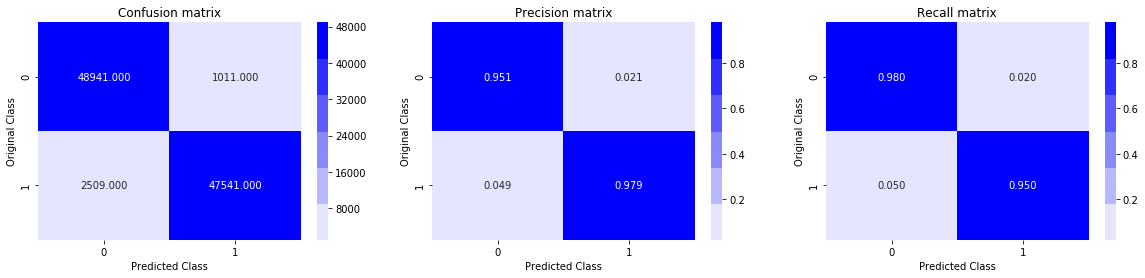

Test confusion_matrix


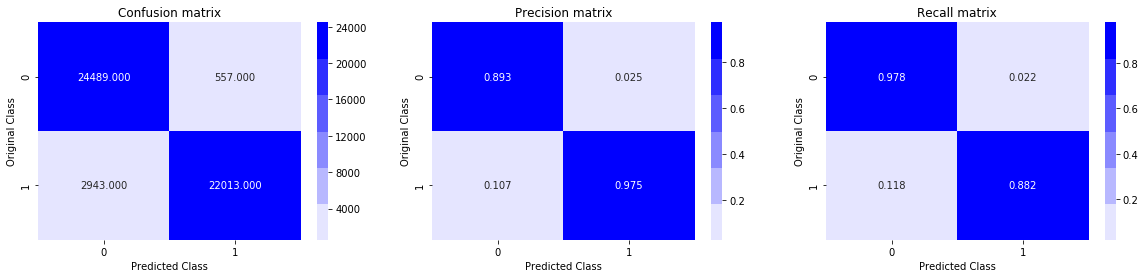

In [29]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

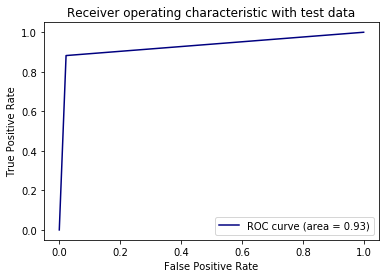

In [30]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

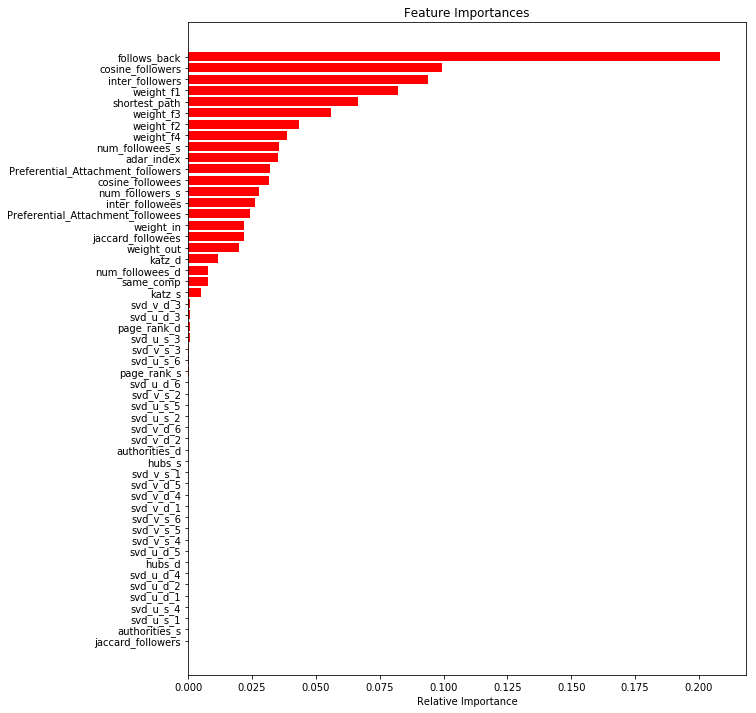

In [31]:
features = df_final_train1.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-55:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

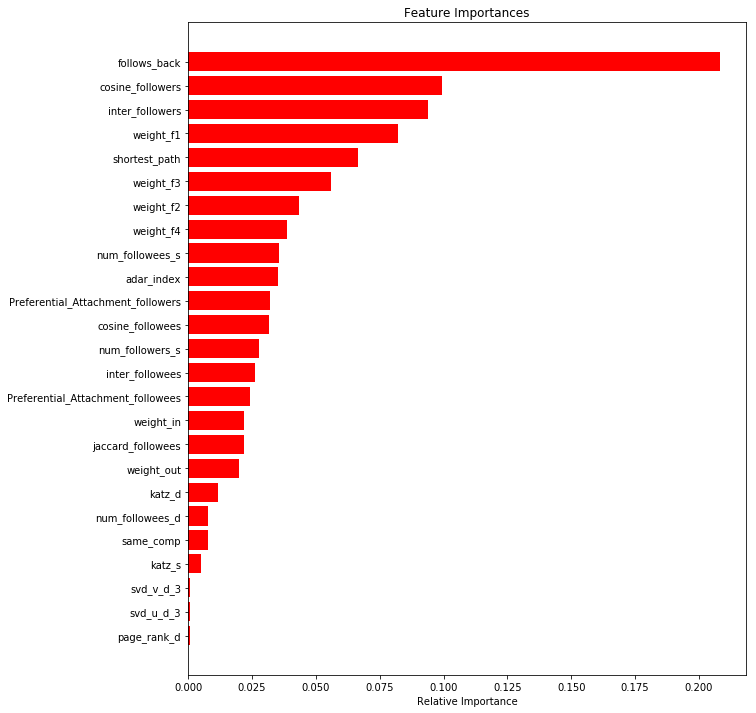

In [32]:
features = df_final_train1.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Here we see that svd_u_d_3, svd_v_s_3,svd_u_s_3,svd_v_d_3,page_rank_d features are not important.So we remove these features

In [33]:
df_final_train1.drop(columns=['svd_v_s_6','authorities_d','svd_u_d_6','svd_u_s_6','svd_u_s_3','svd_v_d_3',
'svd_u_s_1','svd_v_s_5','katz_d','svd_v_s_2','svd_u_s_5','authorities_s','page_rank_d','page_rank_s','svd_u_d_3',
'svd_v_d_1','svd_v_s_4','svd_v_s_3','svd_v_s_1','svd_u_d_5','svd_u_d_4','svd_u_d_2','katz_s',
'svd_u_d_1','svd_u_s_4','svd_u_s_2','hubs_d','hubs_s','svd_v_d_2','svd_v_s_2','svd_v_d_6','svd_v_s_1','svd_v_d_5',
'svd_v_d_4','svd_v_s_6','svd_u_s_1','jaccard_followers']
,axis=1,inplace=True)

In [34]:
df_final_train1.head(5).shape

(5, 20)

In [35]:
df_final_test1.drop(columns=['svd_v_s_6','authorities_d','svd_u_d_6','svd_u_s_6','svd_u_s_3','svd_v_d_3',
'svd_u_s_1','svd_v_s_5','katz_d','svd_v_s_2','svd_u_s_5','authorities_s','page_rank_d','page_rank_s','svd_u_d_3',
'svd_v_d_1','svd_v_s_4','svd_v_s_3','svd_v_s_1','svd_u_d_5','svd_u_d_4','svd_u_d_2','katz_s',
'svd_u_d_1','svd_u_s_4','svd_u_s_2','hubs_d','hubs_s','svd_v_d_2','svd_v_s_2','svd_v_d_6','svd_v_s_1','svd_v_d_5',
'svd_v_d_4','svd_v_s_6','svd_u_s_1','jaccard_followers']
,axis=1,inplace=True)

In [36]:
df_final_test1.head()

,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,Preferential_Attachment_followers,Preferential_Attachment_followees
0,0.0,0.029161,0.000000,14,6,9,1,0,0.000000,1,1,2,0.258199,0.377964,0.636163,0.097590,0.894362,1.014128,84,54
1,0.0,0.000000,0.000000,17,1,19,0,0,0.000000,1,1,7,0.235702,0.707107,0.942809,0.166667,1.178511,1.649916,34,19
2,0.0,0.000000,0.000000,10,16,9,0,0,0.000000,0,1,5,0.301511,0.242536,0.544047,0.073127,0.845558,0.786583,150,144
3,0.0,0.000000,0.000000,37,10,34,0,0,0.000000,0,1,3,0.162221,0.301511,0.463733,0.048912,0.625954,0.765244,407,340
4,0.2,0.042767,0.347833,27,15,27,4,7,6.136433,0,1,2,0.188982,0.250000,0.438982,0.047246,0.627964,0.688982,324,405


after removing useless feature from train and test data, we apply Random Forest Model

Estimators =  10 Train Score 0.9240154358513507 test Score 0.9210604580022943
Estimators =  50 Train Score 0.9254129152762912 test Score 0.9214909136906018
Estimators =  100 Train Score 0.9259788571068284 test Score 0.9217908935469573
Estimators =  250 Train Score 0.9258472794550501 test Score 0.9217483108108108
Estimators =  450 Train Score 0.9254835996635827 test Score 0.9212249208025343


Text(0.5,1,'Estimators vs score at depth of 5')

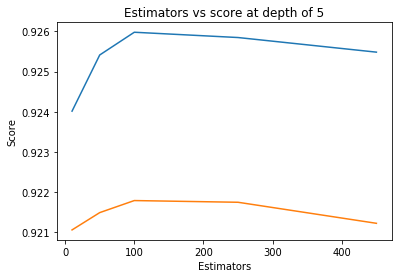

In [37]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train1,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train1))
    test_sc = f1_score(y_test,clf.predict(df_final_test1))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9177071863378554 test Score 0.9126825198164373
depth =  9 Train Score 0.9615185399591725 test Score 0.9249900056809813
depth =  11 Train Score 0.9645096487490107 test Score 0.927333165025667
depth =  15 Train Score 0.9679517706064137 test Score 0.9296343850638826
depth =  20 Train Score 0.9691001285386072 test Score 0.929971399730821
depth =  35 Train Score 0.9689346717396584 test Score 0.9299215743991927
depth =  50 Train Score 0.9689346717396584 test Score 0.9299215743991927
depth =  70 Train Score 0.9689346717396584 test Score 0.9299215743991927
depth =  130 Train Score 0.9689346717396584 test Score 0.9299215743991927


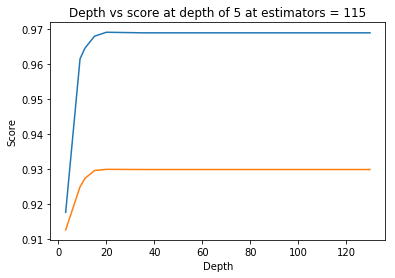

In [38]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train1,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train1))
    test_sc = f1_score(y_test,clf.predict(df_final_test1))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [39]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train1,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96590419 0.96492779 0.96341934 0.96517543 0.96733958]
mean train scores [0.96731122 0.96631352 0.96396201 0.96662327 0.9690713 ]


In [40]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [41]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [42]:
clf.fit(df_final_train1,y_train)
y_train_pred = clf.predict(df_final_train1)
y_test_pred = clf.predict(df_final_test1)

In [43]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9698012387159454
Test f1 score 0.9299087046152552


Train confusion_matrix


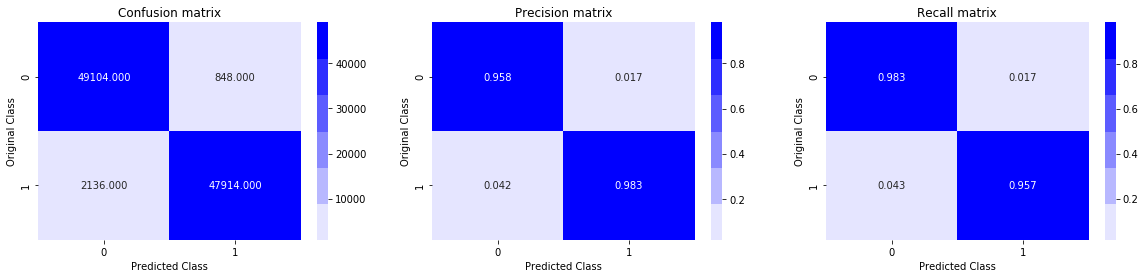

Test confusion_matrix


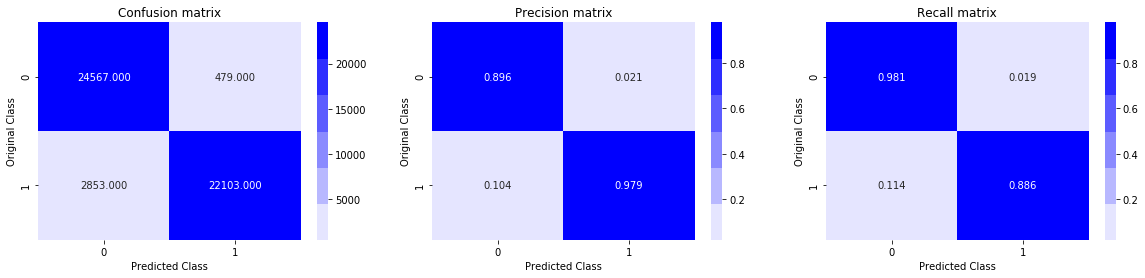

In [44]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

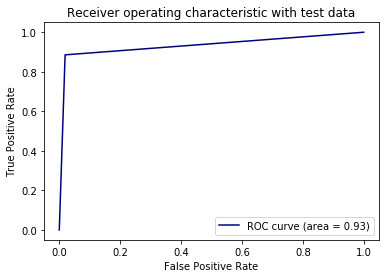

In [45]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

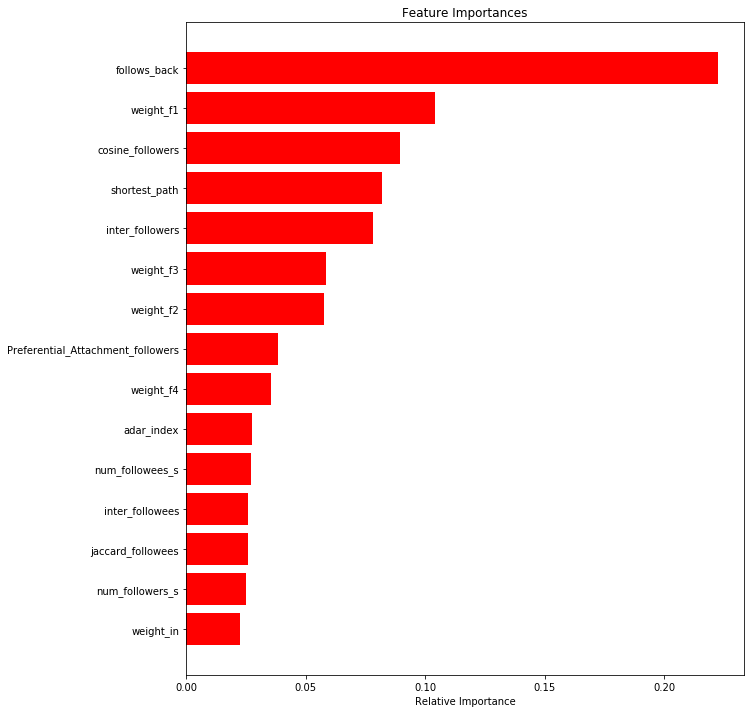

In [46]:
features = df_final_train1.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Logistic Regression Model

In [47]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore')
scaler = StandardScaler()
df_final_train1_sc = scaler.fit_transform(df_final_train1)

df_final_test1_sc = scaler.transform(df_final_test1)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']}

clf = LogisticRegression()

lr_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

lr_random.fit(df_final_train1_sc,y_train)
print('mean test scores',lr_random.cv_results_['mean_test_score'])
print('mean train scores',lr_random.cv_results_['mean_train_score'])

mean test scores [0.90753484 0.9076495  0.90749419 0.90762813 0.90440053]
mean train scores [0.90761892 0.90769743 0.9076801  0.90768805 0.90438172]


In [49]:
print(lr_random.best_estimator_)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [50]:
clf = LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
clf.fit(df_final_train1_sc,y_train)
y_train_pred = clf.predict(df_final_train1_sc)
y_test_pred = clf.predict(df_final_test1_sc)

In [52]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9076550377255798
Test f1 score 0.9099445155783185


Train confusion_matrix


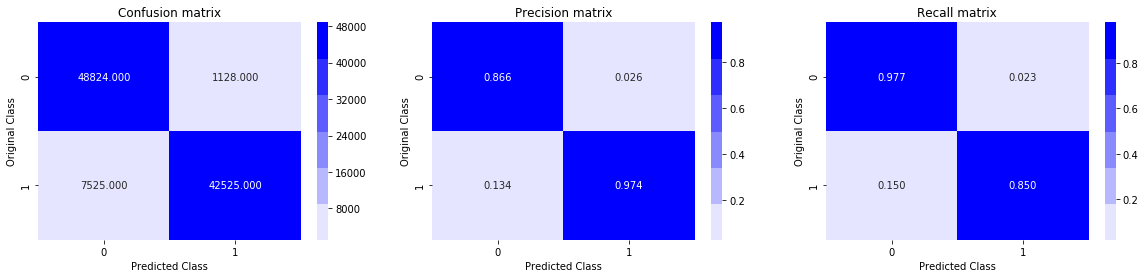

Test confusion_matrix


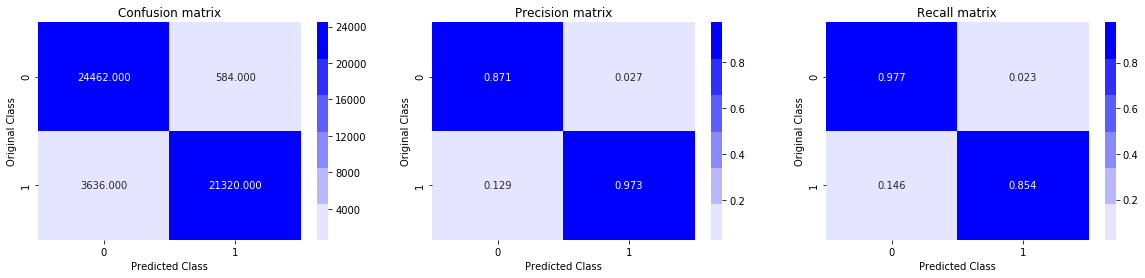

In [53]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

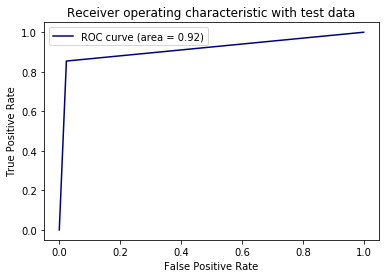

In [54]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

### XGBOOST Model

In [55]:
import xgboost as xgb

base_lerner=list(range(1,100,7))
max_depth=[1, 2, 3, 7, 5, 8, 10]
lr_rate=[0.0001, 0.01,0.1,0.005,0.05,0.5, 1]
param_dist = {'n_estimators':base_lerner, 'max_depth':max_depth, 'learning_rate':lr_rate} #params we need to try on classifier

clf = xgb.XGBClassifier()

xgb_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

xgb_random.fit(df_final_train1_sc,y_train)
print('mean test scores',lr_random.cv_results_['mean_test_score'])
print('mean train scores',lr_random.cv_results_['mean_train_score'])


mean test scores [0.90753484 0.9076495  0.90749419 0.90762813 0.90440053]
mean train scores [0.90761892 0.90769743 0.9076801  0.90768805 0.90438172]


In [56]:
print(xgb_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=64,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [57]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=64,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [58]:
clf.fit(df_final_train1_sc,y_train)
y_train_pred = clf.predict(df_final_train1_sc)
y_test_pred = clf.predict(df_final_test1_sc)

In [59]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9725982843436192
Test f1 score 0.9327352362412983


Train confusion_matrix


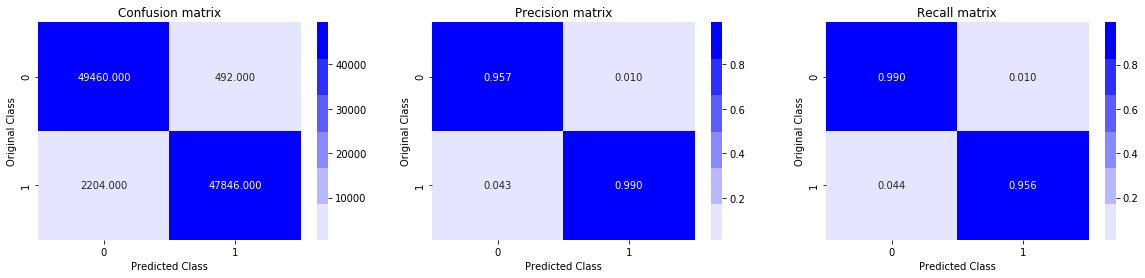

Test confusion_matrix


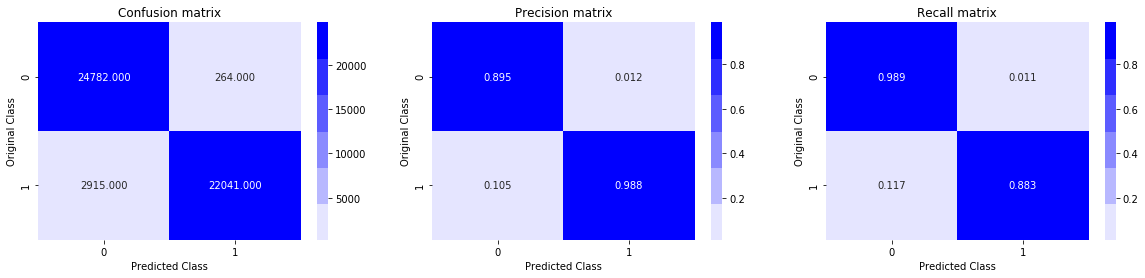

In [60]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

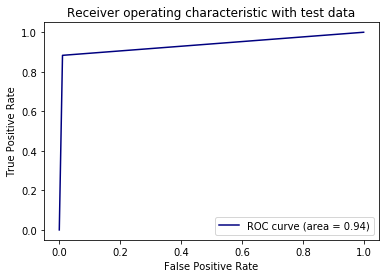

In [61]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

### Decision Tree Model

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
max_depth=[1, 2, 3, 7, 5, 8, 10,12,15]
param_dist = { 'max_depth':max_depth} #params we need to try on classifier

clf = DecisionTreeClassifier()

dt_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

dt_random.fit(df_final_train1,y_train)
print('mean test scores',dt_random.cv_results_['mean_test_score'])
print('mean train scores',dt_random.cv_results_['mean_train_score'])

mean test scores [0.94625529 0.71402788 0.86578215 0.97118955 0.96919625]
mean train scores [0.94709926 0.71407771 0.86579928 0.97581082 0.98102977]


In [63]:
print(dt_random.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [64]:
clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [65]:
clf.fit(df_final_train1,y_train)
y_train_pred = clf.predict(df_final_train1)
y_test_pred = clf.predict(df_final_test1)

In [66]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9756067911989951
Test f1 score 0.932869638528823


Train confusion_matrix


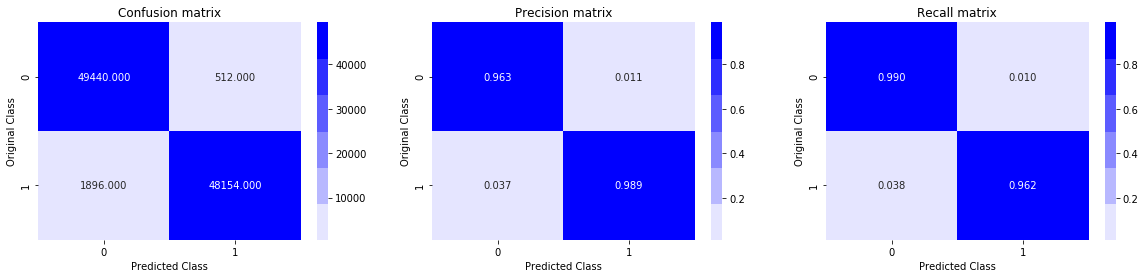

Test confusion_matrix


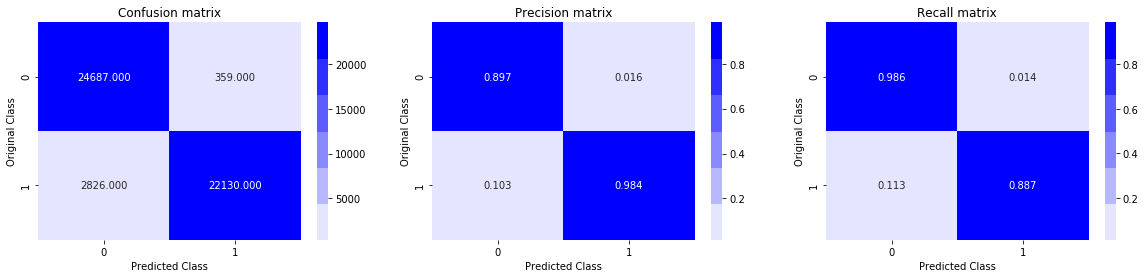

In [67]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

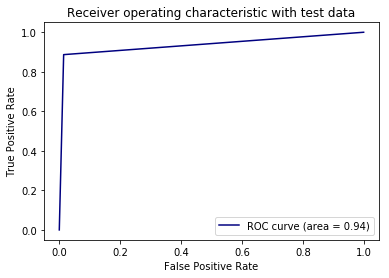

In [68]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

### Analysis of Facebook Friend Recommendation using Graph Mining case study

- We did preprocessing task on dataset.
- We did Exploratory Data Analysis on dataset
    - Nos of followers for each person 
    - Nos of people each person is following
    -  both followers + following
    
    
  
- **We split the data set into train and test data**
    - Number of nodes: 1780722
    - Number of edges: 7550015
    - Average in degree:   4.2399
    - Average out degree:   4.2399
    - Type: DiGraph
    - Number of nodes: 1144623
    - Number of edges: 1887504
    - Average in degree:   1.6490
    - Average out degree:   1.6490
    - no of people common in train and test --  1063125
    - no of people present in train but not present in test --  717597
    - no of people present in test but not present in train --  81498
    - % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %
    - Data points in train data (15100030, 2)
    - Data points in test data (3775008, 2)
    - Shape of traget variable in train (15100030,)
    - Shape of traget variable in test (3775008,)



- **Feature Engineering**
    - we did **Jaccard Distance** Feature Engineering
        - jaccard_for_followees
        - jaccard_for_followers
    - We did **Preferential Attachment** Feature Engineering
        - Preferential_Attachment_for_followers
        - Preferential_Attachment_for_followees
    - We did **Cosine distance (Otsuka-Ochiai coefficient)** Feature Engineering
        - cosine distance for followees
        - cosine distance for followeers
    - We did **Ranking Measures** Feature Engineering
       - Page Rank
    - We did **Shortest path** Feature Engineering
    - We did **Adamic/Adar Index** Feature Engineering
    - **person follow back** Feature Engineering
    - **Katz Centrality** Feature Engineering
    -  **HITS Score** Feature Engineering
    - **Weight Features**
    
    
- **Modeling**
    - We apllied **Random Forest** model
    - We applied **XGBoost** model
    - We applied **Logistic Regression** Model
    - We applied **Decision Tree** moodel
    - We plot the **Confusinon matrix**,**precision** , **recall** and **Roc curves** for each models
    - Overall logistic regression is performing well.